In [1]:
import argparse
from copy import deepcopy
import json
import os
import random
import numpy as np
import pandas as pd
import time

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import random_split

from torchvision import datasets
from torchvision import transforms

In [2]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(0.5, 0.5)])

train_val_dataset = datasets.CIFAR10('./data', train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR10('./data', train=False, transform=transform, download=True)

train_size = int(len(train_val_dataset) * 0.8)
val_size = len(train_val_dataset) - train_size

train_dataset, val_dataset = random_split(train_val_dataset, lengths=[train_size, val_size])

dataset_partition = {'train' : train_dataset, 'val' : val_dataset, 'test' : test_dataset}

Files already downloaded and verified
Files already downloaded and verified


In [3]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, out_dim, act_fn, dropout_prob, n_layer, use_bn, use_weight_init):
        super(MLP, self).__init__()

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        
        self.layers = nn.ModuleList()
        self.bn_layers = nn.ModuleList()

        self.n_layer = n_layer
        self.use_bn = use_bn
        for i in range(self.n_layer-1):
            self.layers.append(nn.Linear(hidden_dim, hidden_dim))

            if self.use_bn:
                self.bn_layers.append(nn.BatchNorm1d(hidden_dim))
        
        self.fc2 = nn.Linear(hidden_dim, out_dim)

        self.act_fn = act_fn

        if self.act_fn == 'relu':
            self.act = nn.ReLU()
        elif self.act_fn == 'tanh':
            self.act = nn.Tanh()
        elif self.act_fn == 'sigmoid':
            self.act = nn.Sigmoid()
        else:
            raise ValueError('Valid activation function should be selected. List of activation function is [relu, tanh, sigmoid]')
        
        
        self.dropout = nn.Dropout(dropout_prob)

        if use_weight_init:
            self._weight_init()


    def _weight_init(self,):

        if self.act_fn == 'relu':
            nn.init.kaiming_normal_(self.fc1.weight)
            nn.init.kaiming_normal_(self.fc2.weight)
            for linear in self.layers:
                if isinstance(linear, nn.Linear):
                    nn.init.kaiming_normal_(linear.weight)
        
        elif self.act_fn == ('tanh' or 'sigmoid'):
            nn.init.xavier_normal_(self.fc1.weight)
            nn.init.xavier_normal_(self.fc2.weight)
            for linear in self.layers:
                if isinstance(linear, nn.Linear):
                    nn.init.xavier_normal_(linear.weight)

    def forward(self, inputs):
        x = self.flatten(inputs)
        x = self.fc1(x)
        for i in range(self.n_layer-1):
            x = self.layers[i](x)
            if self.use_bn:
                x = self.bn_layers[i](x)

            x = self.act(x)
            self.dropout(x)
        output = self.fc2(x)
        return output



model = MLP(3072, 32, 10, 'relu', 0.5, 3, True, True)
model

MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=3072, out_features=32, bias=True)
  (layers): ModuleList(
    (0-1): 2 x Linear(in_features=32, out_features=32, bias=True)
  )
  (bn_layers): ModuleList(
    (0-1): 2 x BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc2): Linear(in_features=32, out_features=10, bias=True)
  (act): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
)

In [4]:
# args.batch_size

def train(model, dataset_partition, optimizer, loss_fn, args, device):
    model = model.to(device)
    model.train()

    train_dataloader = DataLoader(dataset_partition['train'], batch_size=args.batch_size, shuffle=True, drop_last=True)

    train_losses = 0.0
    train_correct = 0.0

    for img, label in train_dataloader:
        img, label = img.to(device), label.to(device)
        optimizer.zero_grad()

        outputs = model(img)
        loss = loss_fn(outputs, label)
        loss.backward()
        optimizer.step()

        train_losses += loss.cpu().detach().numpy()

        prediction = torch.argmax(outputs, dim=-1)
        correct = torch.eq(prediction, label).sum()
        train_correct += correct.cpu().detach().numpy()
    
    train_losses /= len(train_dataloader)
    train_correct /= len(train_dataloader.dataset)
    return model, train_losses, train_correct


def validation(model, dataset_partition, loss_fn, args, device):
    model = model.to(device)
    model.eval()

    valid_dataloader = DataLoader(dataset_partition['val'], batch_size=args.batch_size)

    valid_losses = 0.0
    valid_correct = 0.0

    with torch.no_grad():
        for img, label in valid_dataloader:
            img, label = img.to(device), label.to(device)

            outputs = model(img)
            loss = loss_fn(outputs, label)

            valid_losses += loss.cpu().detach().numpy()
            prediction = torch.argmax(outputs, dim=-1)
            valid_correct += torch.eq(prediction, label).sum().cpu().detach().numpy()
        valid_losses /= len(valid_dataloader)
        valid_correct /= len(valid_dataloader.dataset)
    
    return model, valid_losses, valid_correct


def test(model, dataset_partition, args, device):
    model = model.eval()
    model = model.to(device)

    test_dataloader = DataLoader(dataset_partition['test'], batch_size=args.batch_size)

    test_correct = 0.0
    with torch.no_grad():
        for img, label in test_dataloader:
            img, label = img.to(device), label.to(device)

            outputs = model(img)
            prediction = torch.argmax(outputs, dim=-1)

            correct = torch.eq(prediction, label).sum().cpu().detach().numpy()
            test_correct += correct

    
        test_correct /= len(test_dataloader.dataset)
    return model, test_correct

In [5]:
def experiment(dataset_partition, args, device):
    model = MLP(args.in_dim, args.hidden_dim, args.out_dim, args.act, args.dropout_prob, args.n_layer, args.use_bn, args.use_weight_init)
    model = model.to(device)

    loss_fn = nn.CrossEntropyLoss()

    if args.optim == 'SGD':
        optimizer = torch.optim.SGD(model.parameters(), lr=args.learning_rate)
    elif args.optim == 'Adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=args.learning_rate)
    else:
        raise ValueError('Valid optmizer should be seleceted')
    
    train_losses = []
    valid_losses = []
    train_accs = []
    valid_accs = []

    for epoch in range(args.epoch):
        ts = time.time()
        model, train_loss, train_acc = train(model, dataset_partition, optimizer, loss_fn, args, device)
        model, valid_loss, valid_acc = validation(model, dataset_partition, loss_fn, args, device)
        te = time.time()

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        valid_losses.append(valid_loss)
        valid_accs.append(valid_acc)

        print(f'Epoch {epoch}, ACCURACY(train/valid) : {train_acc * 100:.2f}/{valid_acc * 100 :.2f}. LOSS(train/valid : {train_loss:.2f}/{valid_loss:.2f}. TOOK sec : {te-ts:.2f}')
    
    model, test_acc = test(model, dataset_partition, args, device)

    result = {}
    result['train_losses'] = train_losses
    result['valid_losses'] = valid_losses
    result['train_acc'] = train_accs
    result['valid_acc'] = valid_accs
    result['test_acc'] = test_acc
    return vars(args), result


In [6]:
def save_exp_result(setting:dict, result:dict):
    exp_name = setting['exp_name']

    result.update(setting)
    random_key = int(random.random()*1e7)
    if not os.path.exists('./results'):
        os.mkdir('./results')

    filename = f'./results/{exp_name}_{random_key}.json'

    with open(filename, 'w') as f:
        json.dump(result, f)

def load_exp_result(exp_name):
    dir_path = './results'
    file_names = [f for f in os.listdir(dir_path) if '.json' in f]

    list_results = []

    for file in file_names:
        if exp_name in file:
            with open(os.path.join(dir_path, file), 'r') as f:
                result = json.load(f)
                list_results.append(result)
    df = pd.DataFrame(list_results)
    return df 

In [7]:
# Random Seed initialization
SEED = 123
np.random.seed(SEED)
torch.manual_seed(SEED)

# Device
if torch.cuda.is_available():
    device = torch.device('cpu')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

# Experiment_name
parser = argparse.ArgumentParser()
args = parser.parse_args("")

args.exp_name = 'exp1_bn_weight_init'

# Model capacity
args.in_dim = 3072
args.out_dim = 10
args.hidden_dim = 256
args.act = 'relu'

args.n_layer = 1

# Regularization
args.dropout_prob = 0.2
args.use_bn = True
args.use_weight_init = True

# Optimization & Training
args.optim = 'Adam'
args.epoch = 5
args.batch_size = 256
args.learning_rate = 1e-3

# Experiment values
exp1_var1 = 'use_bn'
exp1_var1_values = [True, False]

exp1_var2 = 'use_weight_init'
exp1_var2_values = [True, False]

for var1 in exp1_var1_values:
    for var2 in exp1_var2_values:
        setattr(args, exp1_var1, var1)
        setattr(args, exp1_var2, var2)
        print(args)

        setting, results = experiment(dataset_partition, args, device)
        save_exp_result(setting, results)
        

Namespace(exp_name='exp1_bn_weight_init', in_dim=3072, out_dim=10, hidden_dim=256, act='relu', n_layer=1, dropout_prob=0.2, use_bn=True, use_weight_init=True, optim='Adam', epoch=5, batch_size=256, learning_rate=0.001)
Epoch 0, ACCURACY(train/valid) : 32.86/36.47. LOSS(train/valid : 2.09/1.87. TOOK sec : 3.43
Epoch 1, ACCURACY(train/valid) : 37.45/35.61. LOSS(train/valid : 1.83/1.90. TOOK sec : 3.21
Epoch 2, ACCURACY(train/valid) : 39.11/38.26. LOSS(train/valid : 1.77/1.80. TOOK sec : 3.29
Epoch 3, ACCURACY(train/valid) : 40.61/39.34. LOSS(train/valid : 1.72/1.76. TOOK sec : 3.37
Epoch 4, ACCURACY(train/valid) : 41.39/40.23. LOSS(train/valid : 1.71/1.76. TOOK sec : 3.35
Namespace(exp_name='exp1_bn_weight_init', in_dim=3072, out_dim=10, hidden_dim=256, act='relu', n_layer=1, dropout_prob=0.2, use_bn=True, use_weight_init=False, optim='Adam', epoch=5, batch_size=256, learning_rate=0.001)
Epoch 0, ACCURACY(train/valid) : 35.58/38.46. LOSS(train/valid : 1.86/1.77. TOOK sec : 3.32
Epoch 1, 

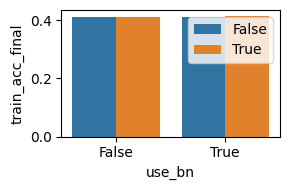

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

exp1_var1 = 'use_bn'
exp1_var2 = 'use_weight_init'

df_exp = load_exp_result('exp1')
df_exp['train_acc_final'] = df_exp.train_acc.apply(lambda x: x[-1])
df_exp['valid_acc_final'] = df_exp.valid_acc.apply(lambda x: x[-1])

fig, ax = plt.subplots(1, 1, figsize=(3, 2))
sns.barplot(x='use_bn', y='train_acc_final', data=df_exp, hue='use_weight_init')
plt.legend()

plt.tight_layout()
plt.show();